## 1. Mengimpor library yang dibutuhkan

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import random
from nltk.corpus import wordnet
from googletrans import Translator
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


## 2. Load Data
Memuat dataset dari file CSV dan menampilkan informasi dasar tentang data seperti tipe data dan jumlah nilai yang hilang.

In [9]:
# Load data
df = pd.read_csv("liputan6.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10972 entries, 0 to 10971
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_article  10972 non-null  object
 1   clean_summary  10972 non-null  object
dtypes: object(2)
memory usage: 257.2+ KB


Menampilkan statistik deskriptif untuk kolom bertipe objek.

In [10]:
df.describe(include='O')

,clean_article,clean_summary
count,10972,10972
unique,10961,10958
top,"Liputan6. com, Jakarta : Di masyarakat, televi...",Sebuah tenda didirikan dekat pintu keluar jala...
freq,4,2


Menampilkan 5 baris pertama dari dataset untuk melihat data.

In [11]:
df.head()

,clean_article,clean_summary
0,"Liputan6. com, Surabaya : Radiogram Direktorat...",Gubernur Jatim Imam Utomo tak mau melantik Bup...
1,"Liputan6. com, Jakarta : Berbeda dengan aliran...",Pelukis RM Koestarto memamerkan hasil karyanya...
2,"Liputan6. com, Jambi : Ratusan orang dari Kesa...","Dua kelompok pengunjuk rasa di Jambi, menuntut..."
3,"Liputan6. com, Jakarta : Badan Penyehatan Perb...",BPPN masih mengkaji bank rekap yang dianggap p...
4,"Liputan6. com, Jakarta : Ketua Komisi I DPR Ya...",Kendati Dewan Papua membatalkan deklarasi keme...


## 2. Selecting Necessary Columns and Dropping NaN Values
Memilih kolom yang relevan ('clean_article' dan 'clean_summary') dan menghapus data yang hilang (NaN).

In [12]:
# Selecting necessary columns and dropping NaN values
data = df[['clean_article', 'clean_summary']].dropna()

In [6]:
# Menampilkan jumlah total data dalam dataset
print("Total data dalam dataset:", len(df))

# Menampilkan jumlah data yang ada di setiap kolom 'clean_article' dan 'clean_summary'
print("Total data di kolom 'clean_article':", df['clean_article'].notnull().sum())
print("Total data di kolom 'clean_summary':", df['clean_summary'].notnull().sum())

# Menjumlahkan total data non-null dari kedua kolom
total_non_null = df['clean_article'].notnull().sum() + df['clean_summary'].notnull().sum()
print("Total dari kedua kolom (clean_article dan clean_summary):", total_non_null)

Total data dalam dataset: 10972
Total data di kolom 'clean_article': 10972
Total data di kolom 'clean_summary': 10972
Total dari kedua kolom (clean_article dan clean_summary): 21944


## 3. Selecting Subset Data and view it
Mengambil 10% data dari data asli untuk digunakan

In [7]:
# Mengambil subset data
df = df.sample(frac=0.10, random_state=50)  # Menggunakan 10% dari dataset

Menampilkan jumlah data terkini

In [8]:
# Menampilkan jumlah total data dalam dataset
print("Total data dalam dataset:", len(df))

# Menampilkan jumlah data yang ada di setiap kolom 'clean_article' dan 'clean_summary'
print("Total data di kolom 'clean_article':", df['clean_article'].notnull().sum())
print("Total data di kolom 'clean_summary':", df['clean_summary'].notnull().sum())

# Menjumlahkan total data non-null dari kedua kolom
total_non_null = df['clean_article'].notnull().sum() + df['clean_summary'].notnull().sum()
print("Total dari kedua kolom (clean_article dan clean_summary):", total_non_null)

Total data dalam dataset: 1097
Total data di kolom 'clean_article': 1097
Total data di kolom 'clean_summary': 1097
Total dari kedua kolom (clean_article dan clean_summary): 2194


## 3. Visualizing Sentiment Distribution and WordCloud
Menggambarkan distribusi sentimen dalam data menggunakan grafik batang.

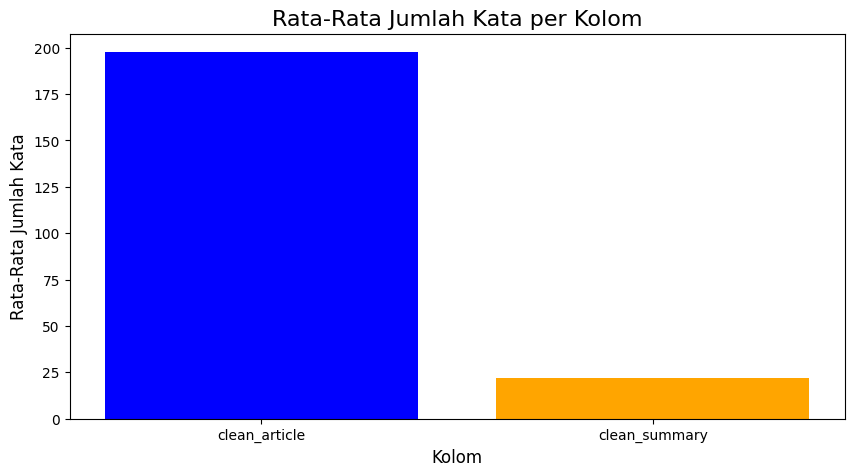

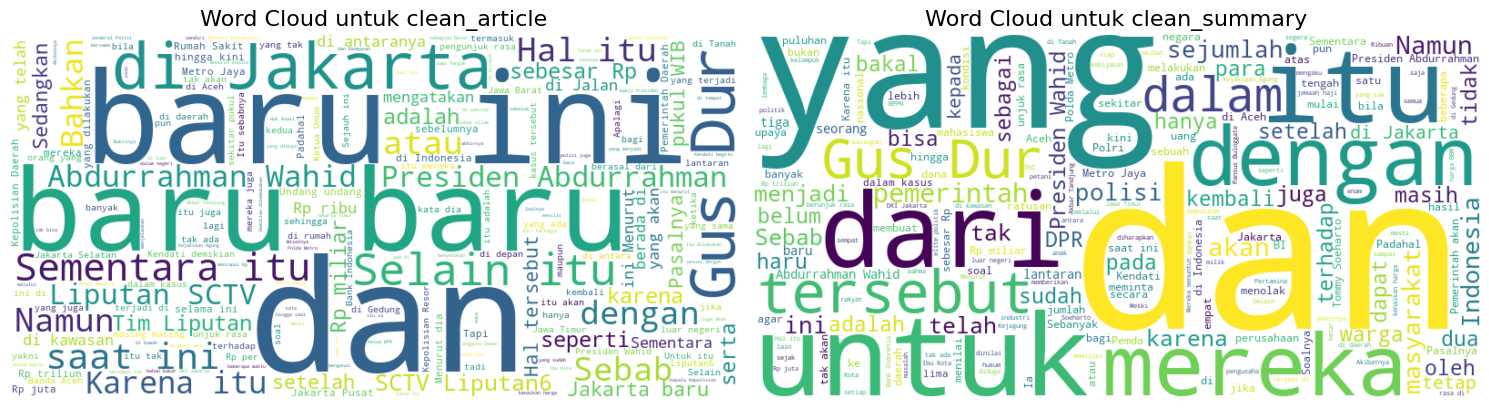

In [9]:
# Menghitung jumlah kata rata-rata untuk clean_article dan clean_summary
df['article_word_count'] = df['clean_article'].apply(lambda x: len(x.split()))
df['summary_word_count'] = df['clean_summary'].apply(lambda x: len(x.split()))

# Menghitung rata-rata jumlah kata
avg_word_count = {
    'clean_article': df['article_word_count'].mean(),
    'clean_summary': df['summary_word_count'].mean()
}

# Membuat bar plot
plt.figure(figsize=(10, 5))
plt.bar(avg_word_count.keys(), avg_word_count.values(), color=['blue', 'orange'])
plt.title('Rata-Rata Jumlah Kata per Kolom', fontsize=16)
plt.ylabel('Rata-Rata Jumlah Kata', fontsize=12)
plt.xlabel('Kolom', fontsize=12)
plt.show()

# Membuat word cloud untuk clean_article
wordcloud_article = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['clean_article']))

# Membuat word cloud untuk clean_summary
wordcloud_summary = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data['clean_summary']))

# Menampilkan word cloud
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_article, interpolation='bilinear')
plt.title('Word Cloud untuk clean_article', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_summary, interpolation='bilinear')
plt.title('Word Cloud untuk clean_summary', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Tokenization, Padding, and Vocab Size

Tokenisasi teks untuk mengonversinya menjadi urutan angka berdasarkan frekuensi kata dalam data pelatihan.

In [13]:
# Menggunakan Tokenizer untuk teks
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_article'].tolist() + df['clean_summary'].tolist())

# Konversi teks menjadi sequences
input_sequences = tokenizer.texts_to_sequences(df['clean_article'].tolist())
target_sequences = tokenizer.texts_to_sequences(df['clean_summary'].tolist())

# Padding sequences untuk memastikan panjangnya seragam
max_input_len = 500  # Batasi panjang maksimum input sequence
max_target_len = 50  # Batasi panjang maksimum target sequence

input_sequences = pad_sequences(input_sequences, maxlen=max_input_len, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_target_len, padding='post')

# Mendapatkan ukuran vocabulary
vocab_size = len(tokenizer.word_index) + 1

## 5. Augmentasi Data
Fungsi untuk augmentasi teks dengan mengganti beberapa kata dengan berbagai metode berikut

In [11]:
# Fungsi untuk augmentasi teks dengan mengganti kata dengan sinonim
def synonym_replacement(text):
    words = text.split()    # Memisahkan teks menjadi kata-kata
    new_words = words.copy()    # Menyalin kata-kata
    word_idx = random.randint(0, len(words)-1)  # Pilih indeks acak
    word = words[word_idx]
    
    # Mendapatkan sinonim
    synonyms = wordnet.synsets(word)
    if synonyms:
        synonym = random.choice(synonyms).lemmas()[0].name()
        new_words[word_idx] = synonym if synonym != word else word  # Pastikan tidak mengganti dengan kata yang sama
    
    return ' '.join(new_words)

# Fungsi back translation (terjemahkan ke bahasa Inggris, kemudian kembali ke bahasa Indonesia)
def back_translation(text, src='id', dest='en'):
    translator = Translator()
    translated = translator.translate(text, src=src, dest=dest).text
    back_translated = translator.translate(translated, src=dest, dest=src).text
    return back_translated

# Fungsi untuk augmentasi dataset
def augment_dataset(df):
    augmented_articles = []
    augmented_summaries = []
    
    for i in range(len(df)):
        article = df.iloc[i]['clean_article']
        summary = df.iloc[i]['clean_summary']
        
        # Menerapkan augmentasi
        augmented_articles.append(synonym_replacement(article))
        augmented_summaries.append(synonym_replacement(summary))
    
    augmented_df = pd.DataFrame({
        'clean_article': augmented_articles,
        'clean_summary': augmented_summaries
    })
    
    return augmented_df

## 6. Membagi Dataset
Membagi data menjadi fitur (X) dan label (y), kemudian membagi data menjadi data pelatihan dan data pengujian.

In [12]:
# Model dengan validasi
X_train, X_val, y_train, y_val = train_test_split(input_sequences, target_sequences, test_size=0.2, random_state=42)

# Menggunakan `max_input_len` untuk padding target sequences
y_train = pad_sequences(y_train, maxlen=max_input_len, padding='post')
y_val = pad_sequences(y_val, maxlen=max_input_len, padding='post')

# Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=256, input_length=max_input_len))  # Dimensi embedding lebih besar
model.add(LSTM(256, return_sequences=True))  # LSTM dengan lebih banyak unit
model.add(Dropout(0.4))  # Dropout lebih tinggi untuk mengurangi overfitting
model.add(LSTM(256, return_sequences=True))  # Layer LSTM kedua
model.add(Dropout(0.4))  # Dropout tambahan
model.add(Dense(vocab_size, activation='softmax'))  # Output layer yang lebih padat
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Gunakan Adam optimizer

# Memastikan model dibangun dengan benar sebelum melihat summary
model.build(input_shape=(None, max_input_len))  # Memaksa model untuk dibangun dengan input shape yang benar
model.summary()  # Menampilkan summary model

e:\Software\Python\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 256)       │     3,945,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 500, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500, 15411)     │     3,960,627 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,956,467 (34.17 MB)

 Trainable params: 8,956,467 (34.17 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Callbacks untuk training
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model
history = model.fit(X_train, y_train, epochs=30, batch_size=160, validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 225s 37s/step - accuracy: 0.5939 - loss: 9.2773 - val_accuracy: 0.9558 - val_loss: 6.9263 - learning_rate: 0.0010
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 218s 36s/step - accuracy: 0.9556 - loss: 6.1397 - val_accuracy: 0.9558 - val_loss: 3.4224 - learning_rate: 0.0010
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 228s 38s/step - accuracy: 0.9556 - loss: 2.7941 - val_accuracy: 0.9558 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 234s 39s/step - accuracy: 0.9557 - loss: 0.8534 - val_accuracy: 0.9558 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 240s 40s/step - accuracy: 0.9554 - loss: 0.5583 - val_accuracy: 0.9558 - val_loss: 0.5445 - learning_rate: 0.0010
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 245s 41s/step - accuracy: 0.9555 - loss: 0.5468 - val_accuracy: 0.9558 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 246s 41s/step - accuracy: 0.9557 - loss: 0.5283 - val_accuracy: 

## 7. Plot Training History
Untuk memvisualisasikan memplot akurasi dan loss selama pelatihan.

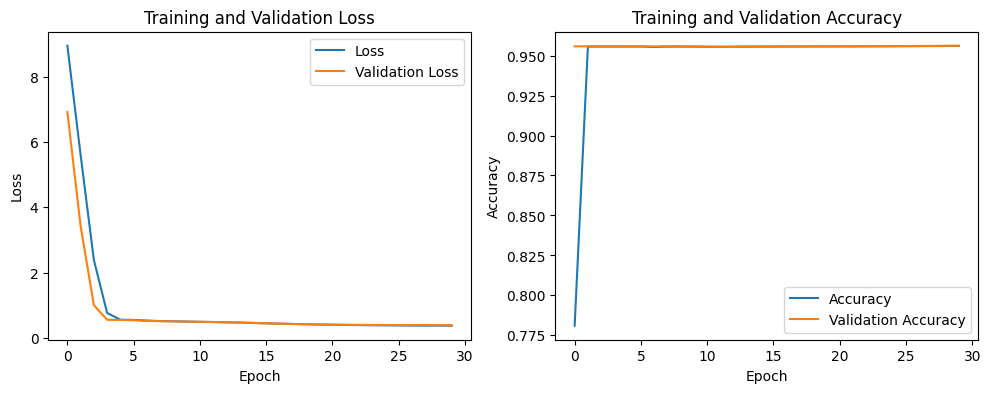

In [14]:
# Plotting Loss dan Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(input_sequences, target_sequences, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Menghitung metrik evaluasi
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
# Menampilkan confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

NameError: name 'model' is not defined

## 8. Implementation 
Implementing the model results by trying to summarize the article

In [15]:
# Fungsi untuk merangkum teks
def summarize_text(input_text, tokenizer, model, max_input_len=500, max_target_len=50):
    # Mengonversi teks input menjadi sequence menggunakan tokenizer
    input_sequence = tokenizer.texts_to_sequences([input_text])
    
    # Padding sequence agar panjangnya sesuai dengan max_input_len
    input_sequence = pad_sequences(input_sequence, maxlen=max_input_len, padding='post')
    
    # Melakukan prediksi untuk teks input
    prediction = model.predict(input_sequence)
    
    # Mengambil indeks yang paling mungkin pada setiap waktu
    predicted_sequence = np.argmax(prediction, axis=-1)[0]
    
    # Mengonversi kembali indeks ke kata-kata
    reverse_word_map = {index: word for word, index in tokenizer.word_index.items()}
    predicted_words = [reverse_word_map.get(index, '') for index in predicted_sequence]
    
    # Mengembalikan hasil sebagai teks yang digabungkan
    return ' '.join(predicted_words).strip()

# Mengambil input teks dari pengguna
input_text = input("Masukkan artikel yang ingin diringkas: ")

# Uji model dengan input teks dinamis
summary = summarize_text(input_text, tokenizer, model)
print("Ringkasan:", summary)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
Ringkasan: di di
